In [24]:
import numpy as np
import huffman
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
import tensorflow_datasets as tfds
import glob
import os
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


Cargar datos

In [2]:
def load_texts(directory):
    texts = []
    # Recorre todos los archivos en el directorio
    for filename in glob.glob(os.path.join(directory, "*")):
        if os.path.isfile(filename):  # Check if the path is a file
            with open(filename, "r", encoding="utf-8", errors="ignore") as file:
                texts.append(file.read())
    return texts

In [3]:

train_dir = "./20news-bydate/20news-bydate-train/rec.autos"
test_dir = "./20news-bydate/20news-bydate-test/rec.autos"
texts_train = load_texts(train_dir)
texts_test = load_texts(test_dir)

In [4]:
def create_sequences(texts, seq_length=40):
    input_chars = []
    output_char = []
    for text in texts:
        for i in range(len(text) - seq_length):
            in_seq = text[i:i + seq_length]
            out_seq = text[i + seq_length]
            input_chars.append(in_seq)
            output_char.append(out_seq)
    return input_chars, output_char

In [5]:
seq_length = 40
texts_train_part = texts_train[:100]
texts_test_part = texts_test[:25]
input_seqs, output_seqs = create_sequences(texts_train_part, seq_length)
input_seqs_test, output_seqs_test = create_sequences(texts_test_part, seq_length)

In [6]:
# Tokenización
tokenizer = Tokenizer(char_level=True,lower=False)
tokenizer.fit_on_texts(texts_test+texts_train)  # Ajuste del tokenizer al corpus completo
vocab_size = len(tokenizer.word_index) + 1

Cargando el modelo (solo si no se va a entrenar)

In [8]:
model = load_model('mi_modelo_tarea2.keras')

model.summary()

/Users/marcofura/anaconda3/envs/fundamentos_matematicos/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 256)        │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 40, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 98)             │        50,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,526,760 (24.90 MB)

 Trainable params: 2,175,586 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,351,174 (16.60 MB)

In [ ]:

# Convertir textos a secuencias numéricas
input_seqs = tokenizer.texts_to_sequences(input_seqs)
input_seqs = pad_sequences(input_seqs, maxlen=seq_length, truncating='pre')

# Preparar datos de salida (etiquetas) usando one-hot encoding
output_seqs = tokenizer.texts_to_sequences(output_seqs)
output_seqs = to_categorical(output_seqs, num_classes=vocab_size)

# Test
input_seqs_test = tokenizer.texts_to_sequences(input_seqs_test)
input_seqs_test = pad_sequences(input_seqs_test, maxlen=seq_length, truncating='pre')

# Preparar datos de salida (etiquetas) usando one-hot encoding
output_seqs_test = tokenizer.texts_to_sequences(output_seqs_test)
output_seqs_test = to_categorical(output_seqs_test, num_classes=vocab_size)

# Construcción del modelo LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length),
    LSTM(512,return_sequences=True),
    Dropout(0.5),
    LSTM(256),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


# Entrenamiento del modelo
model.fit(input_seqs, output_seqs, epochs=50, batch_size=64,validation_data=(input_seqs_test, output_seqs_test),callbacks=[early_stopping,model_checkpoint])

In [9]:
def predict_next_char(model, tokenizer, input_text, seq_length):
    input_seq = tokenizer.texts_to_sequences([input_text])[0]
    
    input_seq = pad_sequences([input_seq], maxlen=seq_length, truncating='pre')
    
    prediction = model.predict(input_seq, verbose=0)[0]
    
    int_to_char = {i: char for char, i in tokenizer.word_index.items()}
    int_to_char[0] = '' 
    return {int_to_char[i]: prob for i, prob in enumerate(prediction)}

In [10]:
input_text = "I am not familiar with, or knowledgeable about the original languag"
predictions = predict_next_char(model, tokenizer, input_text, seq_length)
print(predictions)

{'': 2.8e-06, ' ': 0.05295, 'e': 0.692, 't': 0.003658, 'a': 0.01114, 'o': 0.00689, 'n': 0.0002097, 'i': 0.03314, 'r': 0.003616, 's': 0.0595, 'h': 0.06094, 'l': 0.005043, '\n': 0.002916, 'd': 0.0001464, 'u': 0.005, 'c': 0.0001385, '.': 0.01303, 'm': 0.0003858, 'g': 2.974e-05, 'y': 0.0015135, 'w': 3.4e-05, 'p': 7.42e-05, '-': 0.0008197, 'f': 0.0002266, 'b': 0.001081, '>': 1.72e-05, 'v': 3.093e-05, ',': 0.02934, ':': 3.505e-05, 'k': 0.0001303, 'I': 7.8e-06, 'S': 8e-07, 'T': 1.13e-06, '1': 1.95e-05, '0': 1.1e-06, "'": 0.0005093, 'A': 2.1e-06, ')': 0.003574, '(': 0.0002491, 'C': 1.67e-06, '2': 1.603e-05, '_': 0.000417, '@': 0.0001303, 'R': 1.2e-06, '=': 8.9e-06, 'M': 1.97e-06, '*': 7.7e-06, 'O': 1e-07, '3': 6.4e-06, 'N': 6.6e-07, '9': 2.86e-06, '5': 1.734e-05, 'D': 1.9e-06, 'j': 2.605e-05, 'L': 5.4e-07, 'x': 1.3e-05, '4': 2.444e-05, 'F': 2.8e-06, 'H': 7e-07, 'P': 1.9e-06, 'E': 5.54e-06, 'B': 1.4e-06, 'W': 1.43e-06, '?': 0.00655, 'z': 6.6e-07, '6': 3.7e-06, '|': 4.77e-06, 'U': 1.8e-06, '8': 

In [11]:
max_key = max(predictions, key=predictions.get)
print("Key con mayor valor:", max_key)

Key con mayor valor: e


In [12]:
def codificar_texto(texto:str):
    text_encoded = []
    for i in range(len(texto)):
        input_text = ''
        if i>0:
            input_text=texto[:i]
        print('Texto a predecir:',input_text)
        predictions = predict_next_char(model, tokenizer, input_text, seq_length)
        max_key = max(predictions, key=predictions.get)
        print('Siguiente caracter más probable:',max_key)
        symbolweights = [(char, weight) for char, weight in predictions.items()]
        codigo_huffman = huffman.codebook(symbolweights)
        print('Caracter a codificar:',texto[i])
        texto_codificado =codigo_huffman[texto[i]]
        print('Texto codificado:',texto_codificado)
        text_encoded.append(texto_codificado)
    text_encoded=''.join(text_encoded)
    return text_encoded

In [13]:
def codificar_texto_ascii_binario(texto):
    texto_codificado = ''.join(format(ord(char), '08b') for char in texto)
    return texto_codificado

In [14]:
def codificar_texto_huffman(texto):
    frequencies = Counter(texto)
    symbolweights = [(char, weight) for char, weight in frequencies.items()]
    codigo_huffman = huffman.codebook(symbolweights)
    texto_codificado = ''.join(codigo_huffman[char] for char in texto)
    return texto_codificado

In [25]:
single_texto_test = "I am not familiar with, or knowledgeable about the original languag"

In [15]:
text_encoded_huffman=codificar_texto_huffman(single_texto_test)

In [16]:
text_encoded_ascii=codificar_texto_ascii_binario(single_texto_test)

In [17]:
text_encoded_model=codificar_texto(single_texto_test)

Texto a predecir: 
Siguiente caracter más probable: .
Caracter a codificar: I
Texto codificado: 000111100111
Texto a predecir: I
Siguiente caracter más probable: .
Caracter a codificar:  
Texto codificado: 1101010
Texto a predecir: I 
Siguiente caracter más probable: j
Caracter a codificar: a
Texto codificado: 011
Texto a predecir: I a
Siguiente caracter más probable: n
Caracter a codificar: m
Texto codificado: 11
Texto a predecir: I am
Siguiente caracter más probable: a
Caracter a codificar:  
Texto codificado: 111110
Texto a predecir: I am 
Siguiente caracter más probable: (
Caracter a codificar: n
Texto codificado: 0000011
Texto a predecir: I am n
Siguiente caracter más probable: e
Caracter a codificar: o
Texto codificado: 10
Texto a predecir: I am no
Siguiente caracter más probable: t
Caracter a codificar: t
Texto codificado: 0
Texto a predecir: I am not
Siguiente caracter más probable:  
Caracter a codificar:  
Texto codificado: 1
Texto a predecir: I am not 
Siguiente caracter más

In [20]:
len(text_encoded_huffman),len(text_encoded_ascii),len(text_encoded_model)

(269, 536, 215)

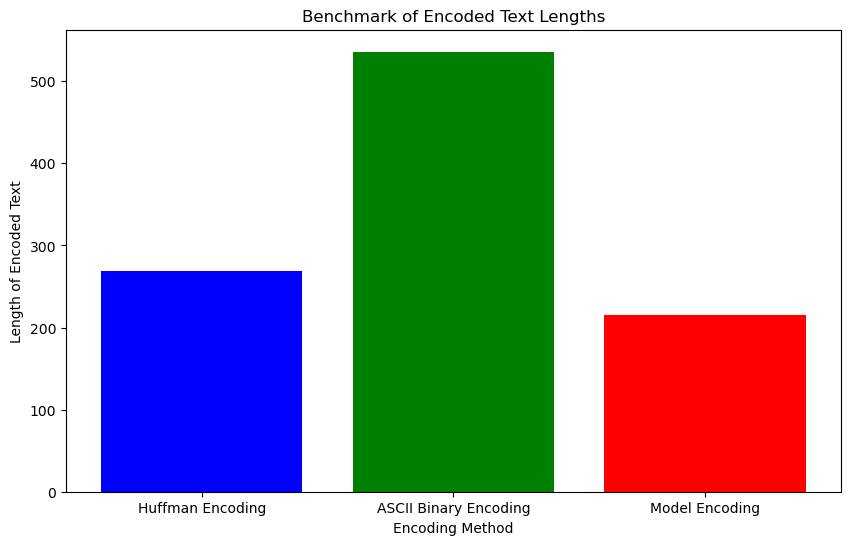

In [23]:

lengths = [len(text_encoded_huffman), len(text_encoded_ascii), len(text_encoded_model)]
labels = ['Huffman Encoding', 'ASCII Binary Encoding', 'Model Encoding']

plt.figure(figsize=(10, 6))
plt.bar(labels, lengths, color=['blue', 'green', 'red'])
plt.xlabel('Encoding Method')
plt.ylabel('Length of Encoded Text')
plt.title('Benchmark of Encoded Text Lengths')
plt.show()

In [18]:
def decodificar_texto_huffman(texto_codificado, codigo_huffman):
    codigo_inverso = {v: k for k, v in codigo_huffman.items()}
    
    texto_decodificado = ''
    temp = ''
    for bit in texto_codificado:
        temp += bit
        if temp in codigo_inverso:
            texto_decodificado += codigo_inverso[temp]
            temp = ''
    
    return texto_decodificado

In [19]:
def decodificador_model(texto_encoded:str):
    texto_decoded = ''
    temp = ''
    codigo_inverso_tmp = {}
    for i in range(len(texto_encoded)):
        if not temp:
            input_text = ''
            if i>0:
                input_text=texto_decoded[:i]
            print('Texto a predecir:',input_text)
            predictions = predict_next_char(model, tokenizer, input_text, seq_length)
            max_key = max(predictions, key=predictions.get)
            print('Siguiente caracter más probable:',max_key)
            symbolweights = [(char, weight) for char, weight in predictions.items()]
            codigo_huffman = huffman.codebook(symbolweights)
            codigo_inverso_tmp = {v: k for k, v in codigo_huffman.items()}
        temp += texto_encoded[i]
        if temp in codigo_inverso_tmp:
            texto_decoded += codigo_inverso_tmp[temp]
            temp = ''
    return texto_decoded

In [21]:
texto_decoded=decodificador_model(text_encoded_model)

Texto a predecir: 
Siguiente caracter más probable: .
Texto a predecir: I
Siguiente caracter más probable: .
Texto a predecir: I 
Siguiente caracter más probable: j
Texto a predecir: I a
Siguiente caracter más probable: n
Texto a predecir: I am
Siguiente caracter más probable: a
Texto a predecir: I am 
Siguiente caracter más probable: (
Texto a predecir: I am n
Siguiente caracter más probable: e
Texto a predecir: I am no
Siguiente caracter más probable: t
Texto a predecir: I am not
Siguiente caracter más probable:  
Texto a predecir: I am not 
Siguiente caracter más probable: (
Texto a predecir: I am not f
Siguiente caracter más probable: r
Texto a predecir: I am not fa
Siguiente caracter más probable: s
Texto a predecir: I am not fam
Siguiente caracter más probable: e
Texto a predecir: I am not fami
Siguiente caracter más probable: n
Texto a predecir: I am not famil
Siguiente caracter más probable: a
Texto a predecir: I am not famili
Siguiente caracter más probable: t
Texto a predecir

In [22]:
texto_decoded

'I am not familiar with, or knowledgeable about the original languag'

Complex text Test

In [27]:
# Ruta del archivo que deseas cargar
file_path = './20news-bydate/20news-bydate-test/rec.autos/103037'

# Cargar el texto del archivo
complex_text_test = ''
with open(file_path, 'r') as file:
    complex_text_test = file.read()

In [28]:
complex_text_test

"From: brian@gothamcity.jsc.nasa.gov (Brian Donnell)\nSubject: Re: Dealer cheated me with wrong odometer reading. Need help!\nNntp-Posting-Host: hotspare.arc.nasa.gov\nOrganization: NASA/ARC Information Sciences Division\nDistribution: usa\nLines: 9\n\nI don't know about where you are, but here in California false\nrepresentation\nof odometer readings is a criminal felony. If you can substantiate this,\nyou need to report that dealer to the local authorities. You should consult\nwith a lawyer to tell you what civil action you can take as well. Keep in\nmind that you will have to prove that the dealer was aware of the change in\nthe dashboard.\n\nBrian Donnell\n"

In [29]:
text_encoded_ascii=codificar_texto_ascii_binario(complex_text_test)
text_encoded_huffman=codificar_texto_huffman(complex_text_test)
text_encoded_model=codificar_texto(complex_text_test)

Texto a predecir: 
Siguiente caracter más probable: .
Caracter a codificar: F
Texto codificado: 000101011011100
Texto a predecir: F
Siguiente caracter más probable: .
Caracter a codificar: r
Texto codificado: 0010100
Texto a predecir: Fr
Siguiente caracter más probable: .
Caracter a codificar: o
Texto codificado: 000001011
Texto a predecir: Fro
Siguiente caracter más probable: .
Caracter a codificar: m
Texto codificado: 1111100
Texto a predecir: From
Siguiente caracter más probable: .
Caracter a codificar: :
Texto codificado: 0001001000101
Texto a predecir: From:
Siguiente caracter más probable: .
Caracter a codificar:  
Texto codificado: 001
Texto a predecir: From: 
Siguiente caracter más probable: j
Caracter a codificar: b
Texto codificado: 1111011
Texto a predecir: From: b
Siguiente caracter más probable: a
Caracter a codificar: r
Texto codificado: 01100
Texto a predecir: From: br
Siguiente caracter más probable: a
Caracter a codificar: i
Texto codificado: 1001
Texto a predecir: Fro

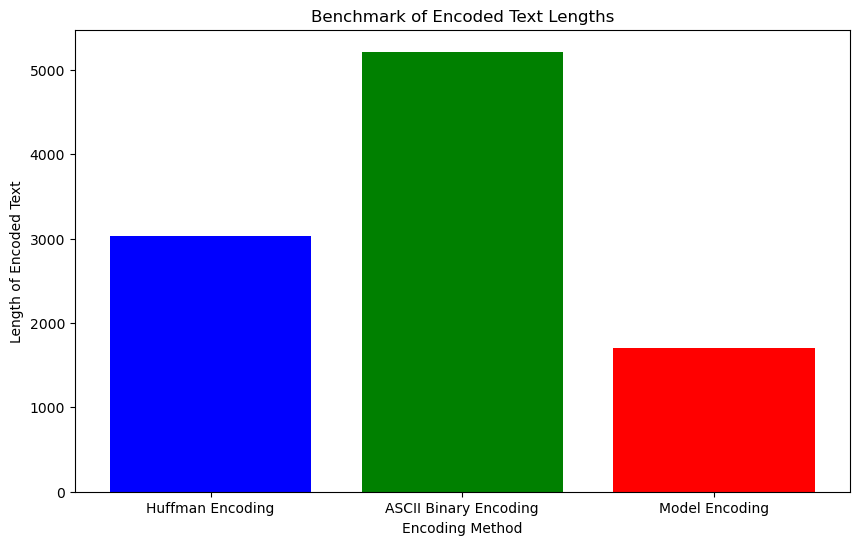

In [30]:

lengths = [len(text_encoded_huffman), len(text_encoded_ascii), len(text_encoded_model)]
labels = ['Huffman Encoding', 'ASCII Binary Encoding', 'Model Encoding']

plt.figure(figsize=(10, 6))
plt.bar(labels, lengths, color=['blue', 'green', 'red'])
plt.xlabel('Encoding Method')
plt.ylabel('Length of Encoded Text')
plt.title('Benchmark of Encoded Text Lengths')
plt.show()

In [31]:
texto_decoded = decodificador_model(text_encoded_model)

Texto a predecir: 
Siguiente caracter más probable: .
Texto a predecir: F
Siguiente caracter más probable: .
Texto a predecir: Fr
Siguiente caracter más probable: .
Texto a predecir: Fro
Siguiente caracter más probable: .
Texto a predecir: From
Siguiente caracter más probable: .
Texto a predecir: From:
Siguiente caracter más probable: .
Texto a predecir: From: 
Siguiente caracter más probable: j
Texto a predecir: From: b
Siguiente caracter más probable: a
Texto a predecir: From: br
Siguiente caracter más probable: a
Texto a predecir: From: bri
Siguiente caracter más probable: d
Texto a predecir: From: bria
Siguiente caracter más probable: d
Texto a predecir: From: brian
Siguiente caracter más probable: d
Texto a predecir: From: brian@
Siguiente caracter más probable: t
Texto a predecir: From: brian@g
Siguiente caracter más probable: r
Texto a predecir: From: brian@go
Siguiente caracter más probable: r
Texto a predecir: From: brian@got
Siguiente caracter más probable: .
Texto a predecir

In [33]:
print(texto_decoded)

From: brian@gothamcity.jsc.nasa.gov (Brian Donnell)
Subject: Re: Dealer cheated me with wrong odometer reading. Need help!
Nntp-Posting-Host: hotspare.arc.nasa.gov
Organization: NASA/ARC Information Sciences Division
Distribution: usa
Lines: 9

I don't know about where you are, but here in California false
representation
of odometer readings is a criminal felony. If you can substantiate this,
you need to report that dealer to the local authorities. You should consult
with a lawyer to tell you what civil action you can take as well. Keep in
mind that you will have to prove that the dealer was aware of the change in
the dashboard.

Brian Donnell

